In [1]:
import keras 
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import string
import re
import matplotlib.pyplot as plt

## Load txt files

In [2]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(directory="/home/jupyter-ozkan_ma/data/TXT/Ablation_Study_02/train/",
                                                          labels="inferred",
                                                          label_mode="categorical",
                                                          batch_size=64,
                                                          validation_split=0.2,
                                                          subset="training",        
                                                          seed=1337)

Found 60000 files belonging to 3 classes.
Using 48000 files for training.


In [3]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(directory="/home/jupyter-ozkan_ma/data/TXT/Ablation_Study_02/train/",
                                                          labels="inferred",
                                                          label_mode="categorical",
                                                          batch_size=64,
                                                          validation_split=0.2,
                                                          subset="validation",
                                                          seed=1337)

Found 60000 files belonging to 3 classes.
Using 12000 files for validation.


In [4]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(directory="/home/jupyter-ozkan_ma/data/TXT/Ablation_Study_02/test/",
                                                         labels="inferred",
                                                         label_mode="categorical",
                                                         batch_size=64)

Found 15000 files belonging to 3 classes.


## Model Constants

In [5]:
max_features = 30000
embedding_dim = 128
sequence_length = 512
epochs=10

In [6]:
vectorize_layer = TextVectorization(max_tokens=max_features,
                                    standardize="lower_and_strip_punctuation",
                                    output_mode="int",
                                    output_sequence_length=sequence_length)

In [7]:
vectorize_layer = TextVectorization(max_tokens=max_features,
                                    standardize="lower_and_strip_punctuation",
                                    output_mode="int",
                                    output_sequence_length=sequence_length)

In [8]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Function to plot accuracy and loss

In [9]:
def plot_train_val_loss(epochs, loss, val_loss):
    
    plt.clf()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [10]:
def plot_train_val_acc(epochs, acc, val_acc):
    
    plt.clf()   # clear figure

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Function to compile and train model, evaluate its performance on the test set

In [11]:
def run_model(input_layer, output_layer, train_data, val_data, test_data):
    
    model = tf.keras.Model(input_layer, output_layer)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    print("Training of the model: \n")
    model_history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callback)
    
    print("Performance of the model to unseen data: \n")
    model.evaluate(test_data)
    
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_x = range(1, len(acc) + 1)
    
    plot_train_val_acc(epochs_x, acc, val_acc)
    plot_train_val_loss(epochs_x, loss, val_loss)

## Core layers and arguments for reusing

In [12]:
# A integer input for vocab indices.
input_layer = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
embedding_layer = Embedding(max_features, embedding_dim)(input_layer)

# We project onto five unit output layer, and squash it with a softmax:
# output_layer = Dense(5, activation="softmax", name="predictions")

In [13]:
callback = EarlyStopping(monitor="val_loss", patience=2)

## Scratch Model from the Keras documentation

In [14]:
lay01 = Dropout(0.5)(embedding_layer)
lay02 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(lay01)
lay03 = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(lay02)
lay04 = GlobalMaxPooling1D()(lay03)
lay05 = Dense(128, activation="relu")(lay04)
lay06 = Dropout(0.5)(lay05)

outputLayer = Dense(3, activation="softmax")(lay06)

Training of the model: 

Epoch 1/10
750/750 [==============================] - 34s 46ms/step - loss: 1.0765 - accuracy: 0.3684 - val_loss: 1.0486 - val_accuracy: 0.3908
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 1.0503 - accuracy: 0.3869 - val_loss: 1.0481 - val_accuracy: 0.3937
Epoch 3/10
750/750 [==============================] - 10s 13ms/step - loss: 1.0482 - accuracy: 0.3871 - val_loss: 1.0453 - val_accuracy: 0.3913
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 1.0469 - accuracy: 0.3900 - val_loss: 1.0446 - val_accuracy: 0.3938
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 1.0458 - accuracy: 0.3885 - val_loss: 1.0445 - val_accuracy: 0.3938
Epoch 6/10
750/750 [==============================] - 9s 12ms/step - loss: 1.0454 - accuracy: 0.3892 - val_loss: 1.0493 - val_accuracy: 0.3887
Epoch 7/10
750/750 [==============================] - 9s 12ms/step - loss: 1.0457 - accuracy: 0.3899 - val_loss: 1.

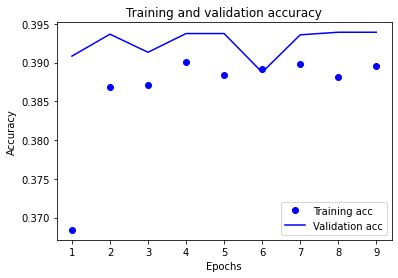

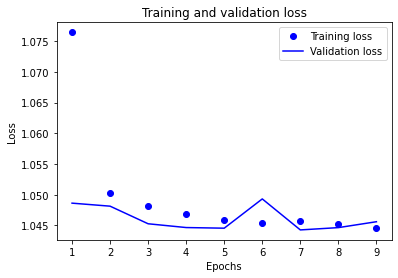

In [15]:
run_model(input_layer, outputLayer, train_ds, val_ds, test_ds)